In [1]:
## code was written using Python 2.7.13 ##
import numpy as np #v1.14.4
import matplotlib.pyplot as plt #v1.5.1
%matplotlib inline
import seaborn as sns #v0.7.1
import scipy.stats as stats #v0.19.0
import scipy.integrate 
import scipy.io as sio
import pandas as pd #0.23.0
import sklearn #0.18.1
from sklearn import svm
from sklearn import linear_model
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import os
from os import listdir
import csv

In [2]:
## Save Figures?
save_figs=['no']

## Save files?
save_files=['yes']

filename='test' ## name to be appended to saved files/figs

colors = ['k','r']

In [3]:
%cd 'C:\Users\Stuber Lab\Desktop\Raw data\satiety imaging'

basedir1 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\satiety imaging\\Pre sated'
basedir2 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\satiety imaging\\Pre hungry'
condition = ['sated','hungry']

maxnumneurons = 1000 #just used to initialize arrays. Should be larger than the total number of neurons
maxframes=2000
framerate=5
maxtrials=10    #number of trials
framespertrial=70
numpreframes=35

## normalize data by baseline?
normalize_on=['yes']
baseline=[20,35]
test=[35,45]

C:\Users\Stuber Lab\Desktop\Raw data\satiety imaging


In [4]:
## Load files in basedir1 and basedir2
def load_files(directory):
    signals_pop = np.nan*np.zeros((maxtrials,framespertrial,maxnumneurons))
    trials_pop=np.nan*np.zeros((maxnumneurons))
    data_dirs = os.walk(directory).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        try:
            signals=np.load(os.path.join(directory,data_dir,'lick_align.npy'))
        except:
            continue
        numneurons=signals.shape[2]
        numframes=signals.shape[1]
        numtrials=signals.shape[0]
#         numtrials=maxtrials
        for a in range(0,numneurons):
            signals_pop[0:numtrials,0:signals.shape[1],numneuronstillnow+a]=signals[0:maxtrials,:,a]
            trials_pop[numneuronstillnow:numneuronstillnow+a+1]=numtrials
        numneuronstillnow += numneurons
    extractedsignals=signals_pop[:,:,:numneuronstillnow]
    trials_pop=trials_pop[:numneuronstillnow]
    print 'files = '+str(data_dirs)
    print '\nNumber of neurons = '+str(extractedsignals.shape[2])
    return extractedsignals,numneuronstillnow,numframes,numneurons,numtrials,trials_pop
extractedsignals1,numneuronstillnow1,numframes1,numneurons1,numtrials1,trials_pop1=load_files(basedir1)
extractedsignals2,numneuronstillnow2,numframes2,numneurons2,numtrials2,trials_pop2=load_files(basedir2)

files = ['B4 FOV1 sated', 'B4 FOV2 sated', 'B5 FOV1 sated', 'B5 FOV2 sated', 'B6 sated', 'G1 sated', 'G10 sated', 'G11 sated', 'G3 sated', 'G4 sated', 'G5 sated', 'G6 sated', 'G7 sated', 'G8 sated', 'G9 sated']

Number of neurons = 452
files = ['B4 FOV1 hungry', 'B4 FOV2 hungry', 'B5 FOV1 hungry', 'B5 FOV2 hungry', 'B6 hungry', 'G1 hungry', 'G10 hungry', 'G11 hungry', 'G3 hungry', 'G4 hungry', 'G5 hungry', 'G6 hungry', 'G7 hungry', 'G8 hungry', 'G9 hungry']

Number of neurons = 452


In [5]:
#normalize data by baseline period
if normalize_on[0]=='yes':
    def normalize_data(data):
        BLnorm=np.nan*np.zeros((data.shape))
        BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
        for b in range(0,data.shape[2]):
            for a in range(0,data.shape[0]):
                BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
        for e in range(0,data.shape[2]):
            for d in range(0,data.shape[1]):
                for c in range(0,data.shape[0]):
                    BLnorm[c,d,e]=data[c,d,e]-BLavg[c,e]
        reshape_response=BLnorm
        return reshape_response
    extractedsignals1_norm=normalize_data(extractedsignals1)
    extractedsignals2_norm=normalize_data(extractedsignals2)
else:
    extractedsignals1_norm=extractedsignals1
    extractedsignals2_norm=extractedsignals2

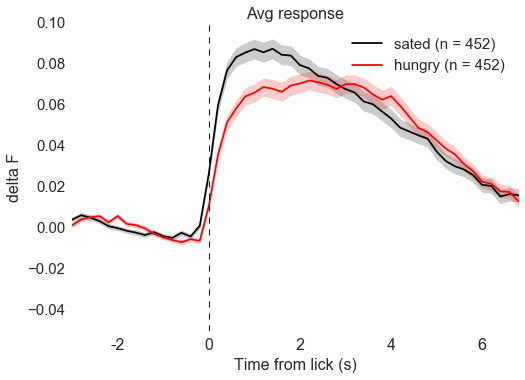

In [6]:
## Generate population average (Fig. 3G) ##

avg_response1=np.nanmean(extractedsignals1_norm,axis=0)
avg_response2=np.nanmean(extractedsignals2_norm,axis=0)
peak_response1=np.nanmax(avg_response1[test[0]:test[1],:],axis=0)
peak_response2=np.nanmax(avg_response2[test[0]:test[1],:],axis=0)
avg_rew_response1=np.nanmean(avg_response1[test[0]:test[1],:],axis=0)
avg_rew_response2=np.nanmean(avg_response2[test[0]:test[1],:],axis=0)
if save_files[0]=='yes':
    np.savetxt(filename+'_avg_response_'+condition[0]+'.csv',avg_rew_response1.T,delimiter=',')
    np.savetxt(filename+'_avg_response_'+condition[1]+'.csv',avg_rew_response2.T,delimiter=',')
    np.savetxt(filename+'_peak_response_'+condition[0]+'.csv',peak_response1.T,delimiter=',')
    np.savetxt(filename+'_peak_response_'+condition[1]+'.csv',peak_response2.T,delimiter=',')
    np.savetxt(filename+'_all_data_'+condition[0]+'.csv',avg_response1.T,delimiter=',')
    np.savetxt(filename+'_all_data_'+condition[1]+'.csv',avg_response2.T,delimiter=',')
#remove frames preceding start of baseline window
avg_response1=avg_response1[baseline[0]:,:]
avg_response2=avg_response2[baseline[0]:,:]
framespertrial=framespertrial-baseline[0]

ymin=-.05
ymax=.1
sns.set(font_scale=1.5)
fig1,ax = plt.subplots(1)
sns.tsplot(avg_response1.T,color=colors[0], condition=condition[0]+' (n = '+str(extractedsignals1.shape[2])+')', legend=True)
sns.tsplot(avg_response2.T,color=colors[1], condition=condition[1]+' (n = '+str(extractedsignals2.shape[2])+')', legend=True)
ax.set_title('Avg response',fontsize='16')
ax.set_xlabel('Time from lick (s)',fontsize='16')
ax.set_ylabel('delta F',fontsize='16')
ax.set_axis_bgcolor('white')
# ax.set_yticks([1,1.1,1.2])
ax.set_ylim(ymin,ymax)
ax.set_xticks(range(5, framespertrial+1, 10))
ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [ymin, ymax], '--k', linewidth=1)
ax.plot([0, framespertrial], [1, 1], '--k', linewidth=1)
if save_figs[0]=='yes':
    plt.savefig((filename+'_pop_response_overlay'+'.pdf'), format='pdf')
    plt.savefig((filename+'_pop_response_overlay'+'.png'), format='png')
    plt.show()

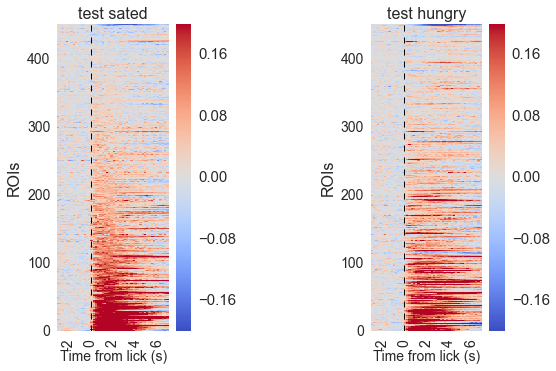

In [7]:
# plot population heatmaps (Fig. 3H)
sortneurons = np.argsort(np.nanmean(avg_response1[15:30,:], axis=0))
fig4 = plt.figure(4)
ax = plt.subplot(121)
sns.heatmap(avg_response1[:,sortneurons].T, cmap=plt.get_cmap('coolwarm'), vmin=-.2, vmax=.2,linewidth=0)
ax.set_title(filename+' '+str(condition[0]), fontsize=16)
ax.set_xlabel('Time from lick (s)', fontsize=14, labelpad=-1)
ax.set_xticks(range(5, framespertrial+1, 10))
ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [0, extractedsignals1.shape[2]], '--k', linewidth=1)
ax.set_yticks(range(0, extractedsignals1.shape[2], 100))
ax.set_yticklabels([str(a) for a in range(0,extractedsignals1.shape[2],100)],fontsize='14')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.ylabel('ROIs', fontsize='16')
fig4.tight_layout(w_pad=5)

fig5 = plt.figure(4)
ax = plt.subplot(122)
sns.heatmap(avg_response2[:,sortneurons].T, cmap=plt.get_cmap('coolwarm'), vmin=-.2, vmax=.2,linewidth=0)
ax.set_title(filename+' '+str(condition[1]), fontsize=16)
ax.set_xlabel('Time from lick (s)', fontsize=14, labelpad=-1)
ax.set_xticks(range(5, framespertrial+1, 10))
ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [0, extractedsignals2.shape[2]], '--k', linewidth=1)
ax.set_yticks(range(0, extractedsignals2.shape[2], 100))
ax.set_yticklabels([str(a) for a in range(0,extractedsignals2.shape[2],100)],fontsize='14')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.ylabel('ROIs', fontsize='16')
fig5.tight_layout(w_pad=5)
if save_figs[0]=='yes':
    plt.savefig(filename+'_population_heatmap.pdf', format='pdf')
plt.show()

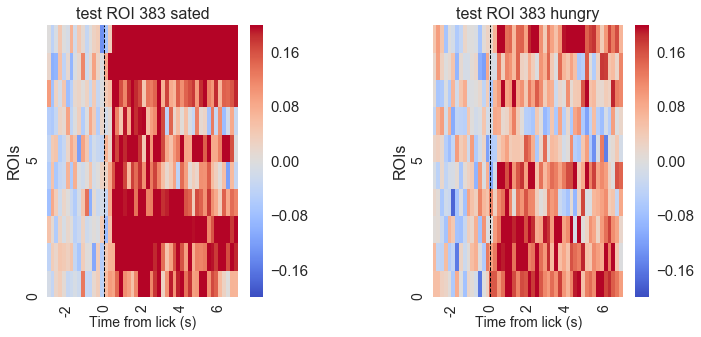

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:44: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


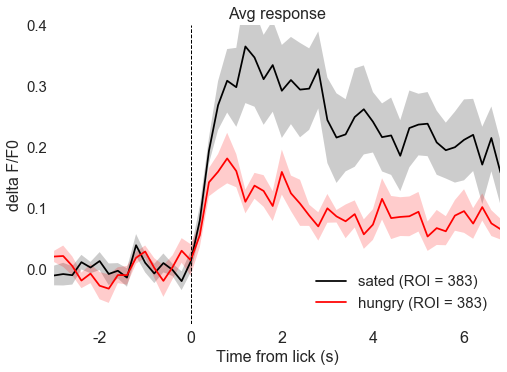

In [8]:
# Plot and export example cell data (Fig. 3E,F)
i=383
fig10 = plt.figure(1,figsize=(10,5))
ax = plt.subplot(121)
sns.heatmap(extractedsignals1_norm[:,baseline[0]:,i], cmap=plt.get_cmap('coolwarm'), vmin=-.2, vmax=.2,center=0,linewidth=0)
ax.set_title(filename+' ROI '+str(i)+' '+str(condition[0]), fontsize=16)
ax.set_xlabel('Time from lick (s)', fontsize=14, labelpad=-1)
ax.set_xticks(range(5, framespertrial+1, 10))
ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [0, extractedsignals1.shape[0]], '--k', linewidth=1)
ax.set_yticks(range(0, extractedsignals1.shape[0], 5))
ax.set_yticklabels([str(a) for a in range(0,extractedsignals1.shape[0],5)],fontsize='14')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.ylabel('ROIs', fontsize='16')
fig10.tight_layout(w_pad=5)

fig11 = plt.figure(1,figsize=(10,5))
ax = plt.subplot(122)
sns.heatmap(extractedsignals2_norm[:,baseline[0]:,i], cmap=plt.get_cmap('coolwarm'), vmin=-.2, vmax=.2, center=0,linewidth=0)
ax.set_title(filename+' ROI '+str(i)+' '+str(condition[1]), fontsize=16)
ax.set_xlabel('Time from lick (s)', fontsize=14, labelpad=-1)
ax.set_xticks(range(5, framespertrial+1, 10))
ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [0, extractedsignals1.shape[0]], '--k', linewidth=1)
ax.set_yticks(range(0, extractedsignals1.shape[0], 5))
ax.set_yticklabels([str(a) for a in range(0,extractedsignals2.shape[0],5)],fontsize='14')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.ylabel('ROIs', fontsize='16')
fig11.tight_layout(w_pad=5)
plt.show()

# Overlay example cell data ##
ymin=-.09
ymax=.4
sns.set(font_scale=1.5)
fig12,ax = plt.subplots(1)
sns.tsplot(extractedsignals1_norm[:,baseline[0]:,i],color=colors[0], condition=condition[0]+' (ROI = '+str(i)+')', legend=True)
sns.tsplot(extractedsignals2_norm[:,baseline[0]:,i],color=colors[1], condition=condition[1]+' (ROI = '+str(i)+')', legend=True)
ax.set_title('Avg response',fontsize='16')
ax.set_xlabel('Time from lick (s)',fontsize='16')
ax.set_ylabel('delta F/F0',fontsize='16')
ax.set_axis_bgcolor('white')
ax.set_ylim(ymin,ymax)
ax.set_xticks(range(5, framespertrial+1, 10))
ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [ymin, ymax], '--k', linewidth=1)
ax.plot([0, framespertrial], [1, 1], '--k', linewidth=1)
if save_files[0]=='yes':
    np.savetxt(filename+'_ROI_'+str(i)+'_condition_'+str(condition[0])+'.csv',extractedsignals1_norm[:,:,i].T,delimiter=',')
    np.savetxt(filename+'_ROI_'+str(i)+'_condition_'+str(condition[1])+'.csv',extractedsignals2_norm[:,:,i].T,delimiter=',')
if save_figs[0]=='yes':
    plt.savefig((filename+'_ROI_'+str(i)+' response_overlay'+'.pdf'), format='pdf')
    plt.show()

In [9]:
## find AUC for each neuron using trapz method (For Fig. 3I) ##
time1=15 #frames in baseline corrected data to include in AUC calculation
time2=30
def auc(data):
    AUC=np.nan*np.zeros((data.shape[1]))
    for i in range(0,data.shape[1]):
        AUC[i] = scipy.integrate.trapz(y=data[time1:time2,i])
    return AUC
auc_condition1=auc(avg_response1)
auc_condition2=auc(avg_response2)
if save_files[0]=='yes':
    np.savetxt(filename+'_AUC_'+condition[0]+'.csv',auc_condition1.T,delimiter=',')
    np.savetxt(filename+'_AUC_'+condition[1]+'.csv',auc_condition2.T,delimiter=',')

In [10]:
##combine arrays ##
def combine_arrays(data1,data2):
    max_events=[data1.shape[0],data2.shape[0]]
    max_events=np.max(max_events)
    combined_array=np.nan*np.zeros((max_events,2))
    combined_array[:data1.shape[0],0]=data1
    combined_array[:data2.shape[0],1]=data2
    return combined_array
peak_amp_combined=combine_arrays(peak_response1,peak_response2)
avg_response_combined=combine_arrays(avg_rew_response1,avg_rew_response2)
peak_sated,peak_hungry=np.split(peak_amp_combined,2,axis=1)
avg_sated,avg_hungry=np.split(avg_response_combined,2,axis=1)
zeros=np.zeros((avg_sated.shape[0]))
ones=np.ones((avg_hungry.shape[0]))
sated_df=pd.DataFrame({'peak':peak_sated[:,0],'avg':avg_sated[:,0],'condition':zeros})
hungry_df=pd.DataFrame({'peak':peak_hungry[:,0],'avg':avg_hungry[:,0],'condition':ones})
df=sated_df.append(hungry_df,ignore_index=True)
df=df.dropna(axis=0)

('prediction accuracy = ', 0.57037943696450433)
('shuffled accuracy = ', 0.5483476132190942)
0
('prediction accuracy = ', 0.58536585365853655)
('shuffled accuracy = ', 0.5280487804878049)
1
('prediction accuracy = ', 0.57125456760048721)
('shuffled accuracy = ', 0.53836784409256999)
2
('prediction accuracy = ', 0.57439024390243898)
('shuffled accuracy = ', 0.54024390243902443)
3
('prediction accuracy = ', 0.57810578105781063)
('shuffled accuracy = ', 0.52767527675276749)
4
('prediction accuracy = ', 0.57384987893462469)
('shuffled accuracy = ', 0.52421307506053272)
5
('prediction accuracy = ', 0.57725587144622992)
('shuffled accuracy = ', 0.54758961681087759)
6
('prediction accuracy = ', 0.57318573185731858)
('shuffled accuracy = ', 0.55227552275522751)
7
('prediction accuracy = ', 0.58353808353808356)
('shuffled accuracy = ', 0.55528255528255532)
8
('prediction accuracy = ', 0.57334963325183375)
('shuffled accuracy = ', 0.52200488997555017)
9
('prediction accuracy = ', 0.5707133917396

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:39: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


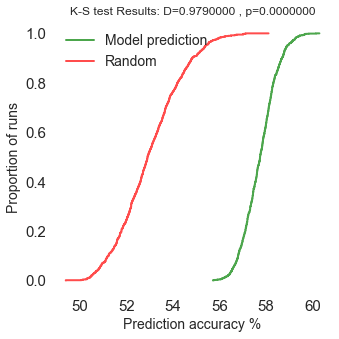

57.7410962723
53.0139883048


In [31]:
##Use SVM to classify data based on 'group' (Fig. 3J) ##
iterations=1000 #Define number of iterations
test_data=.1  #defines split for test/train sets
test=[35,45]

parameters = [{'C': [0.001, .01,.1,1,10,100,1000], 'kernel': ['linear']},
              {'C': [0.001, .01,.1,1,10,100,1000], 'gamma': [0.001, .01,.1,1,10,100,1000], 'kernel': ['rbf']}]

pred_score=np.nan*np.zeros((iterations))
rand_score=np.nan*np.zeros((iterations))
for i in range(iterations):
    ##randomly subset df into test and train sets
    msk = np.random.rand(len(df))>test_data
    train = df[msk]
#     print ('train set = ', train.shape)
    clf = GridSearchCV(SVC(), parameters,cv=10)
    train_labels=train[['condition']].values
    c,r=train_labels.shape
    train_labels=train_labels.reshape(c,)
    clf.fit(train[['avg','peak']], train_labels)
    print ('prediction accuracy = ', clf.best_score_)
    pred_score[i]=(clf.best_score_)*100
    ##random array of 1s and 0s for shuffled classifier
    rand_group=pd.DataFrame(np.random.randint(2,size=train.shape[0]))
    clf.fit(train[['avg','peak']], rand_group[0])
    print ('shuffled accuracy = ', clf.best_score_)
    rand_score[i]=(clf.best_score_)*100
    print i

plt.figure(figsize=(5,5))
ax=plt.subplot(111)
n = np.arange(1,len(pred_score)+1) / np.float(len(pred_score))
Xs = np.sort(pred_score)
plt.step(Xs,n,color='g',label='Model prediction',alpha=0.7,linewidth=2)
n2= np.arange(1,len(rand_score)+1) / np.float(len(rand_score))
Xs2= np.sort(rand_score)
plt.step(Xs2,n,color='r',label='Random',alpha=0.7,linewidth=2)

ax.set_axis_bgcolor('white')
plt.xlabel('Prediction accuracy %',fontsize=14)
plt.ylabel('Proportion of runs',fontsize=14)
plt.legend(fontsize=14,loc=2)
plt.savefig(str(iterations)+str('iter_')+str(test_data)+'test_data_prediction_accuracy_hist.pdf')
np.savetxt(filename+str(iterations)+'iterations_'+str(test_data)+'split_prediction_accuracy.csv',pred_score,delimiter=',')
np.savetxt(filename+str(iterations)+'iterations_'+str(test_data)+'split_RANDOM_prediction_accuracy.csv',rand_score,delimiter=',')
plt.show()

print np.nanmean(pred_score)
print np.nanmean(rand_score)

Excited =  309
Inhibited =  69
Null =  74


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:129: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 70 but corresponding boolean dimension is 10
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:131: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 70 but corresponding boolean dimension is 10


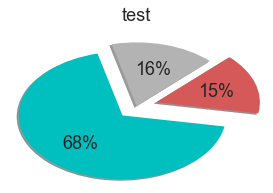

Excited =  361
Inhibited =  44
Null =  47


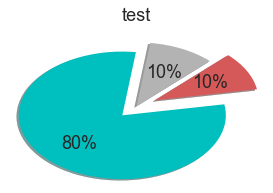

In [14]:
## calculate number of significant neurons (Fig. S5f) ##

# type of t-test ('independent','paired', or 'wilcoxon')
#p-value (two-tailed) to consider significant
def calc_sig(basedir,test_type,sig_pvalue):
    framerate=5
    numtrials=10   #number of trials
    baseline_dur=10 #how long is baseline (in s)
    stimulus_dur=10 #how long is stimulus window (in s)
    trial_length=20 #how long is each trial (in s)
    maxnumneurons = 1000 #just used to initialize arrays. Should be larger than the total number of neurons
    baseline=[20,35]
    test=[35,50]
    ## normalize data by baseline?
    normalize_on=['no']
    numpreframes=35
    numtestframes=15
    numframespertrial=70
    rewardresponse_pop = np.zeros((maxnumneurons,2));rewardresponse_pop[:]=np.nan
    avgtrace_pop = np.zeros((maxnumneurons,numframespertrial));avgtrace_pop[:] = np.nan
    sig_excited_neurons = np.zeros((maxnumneurons,1));sig_excited_neurons[:]=np.nan
    sig_inhibited_neurons = np.zeros((maxnumneurons,1));sig_inhibited_neurons[:]=np.nan
    combine_all_data=np.zeros((maxnumneurons,numframespertrial,numtrials));combine_all_data[:]=np.nan
    listdir(basedir)

    data_dirs = os.walk(basedir).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        signals=np.load(os.path.join(basedir,data_dir,'lick_align.npy'))
        numtrials=signals.shape[0]
        signals=signals[0:numtrials,:,:]
        numneurons=signals.shape[2]
        numframes=signals.shape[1]
        reshape_response=np.zeros((numneurons,numframespertrial,numtrials));reshape_response[:]=np.nan
        reshape_response=np.swapaxes(signals,0,2)

        #normalize data by baseline period
        if normalize_on[0]=='yes':
            def normalize_data(data):
                BLnorm=np.nan*np.zeros((data.shape))
                BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
                for b in range(0,data.shape[2]):
                    for a in range(0,data.shape[0]):
                        BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
                for e in range(0,data.shape[2]):
                    for d in range(0,data.shape[1]):
                        for c in range(0,data.shape[0]):
                            BLnorm[c,d,e]=data[c,d,e]/BLavg[c,e]
                reshape_response=BLnorm
                return reshape_response
            reshape_response=normalize_data(reshape_response)
        else:
            reshape_response=reshape_response
        avgresponse=np.nanmean(reshape_response, axis=2)

        stimulusresponse=np.zeros((numneurons,numtrials,2));stimulusresponse[:]=np.nan
        testsig_ind=np.zeros((numneurons,2))#;stats[:]=np.nan
        testsig_paired=np.zeros((numneurons,2))#;stats[:]=np.nan
        for a in range(0,numneurons):
            avgtrace_pop[numneuronstillnow+a,:]=avgresponse[a,:]
            combine_all_data[numneuronstillnow+a,:,:numtrials]=reshape_response[a,:,:numtrials]
            for b in range(0,numtrials):
                stimulusresponse[a,b,0]=np.nanmean(reshape_response[a,test[0]:test[1],b])
                stimulusresponse[a,b,1]=np.nanmean(reshape_response[a,baseline[0]:baseline[1],b])
            if test_type=='independent':
                testsig_paired[a,:]=stats.ttest_ind(stimulusresponse[a,:,0],stimulusresponse[a,:,1],equal_var=False)
                rewardresponse_pop[numneuronstillnow+a,:]=testsig_paired[a,:]
            if test_type=='paired':
                testsig_paired[a,:]=stats.ttest_rel(stimulusresponse[a,:,0],stimulusresponse[a,:,1])
                rewardresponse_pop[numneuronstillnow+a,:]=testsig_paired[a,:]
            if test_type=='wilcoxon':
                testsig_paired[a,:]=stats.wilcoxon(stimulusresponse[a,:,0],stimulusresponse[a,:,1],zero_method='wilcox')
                rewardresponse_pop[numneuronstillnow+a,:]=testsig_paired[a,:]
        sig_excited_neurons_temp=np.zeros((numneurons,1));sig_excited_neurons_temp[:]=np.nan
        sig_inhibited_neurons_temp=np.zeros((numneurons,1));sig_inhibited_neurons_temp[:]=np.nan
        if test_type=='wilcoxon':
            for a in range(0,numneurons):
                sig_excited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,1]<sig_pvalue,
                                                               np.nanmean(stimulusresponse[a,:,0],axis=0)>
                                                               np.nanmean(stimulusresponse[a,:,1],axis=0))
                sig_inhibited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,1]<sig_pvalue,
                                                                 np.nanmean(stimulusresponse[a,:,0],axis=0)<
                                                                 np.nanmean(stimulusresponse[a,:,1],axis=0))
        else:
            for a in range(0,numneurons):
                sig_excited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,0]>0,rewardresponse_pop[a,1]<sig_pvalue)    
                sig_inhibited_neurons_temp[a,:] = np.logical_and(rewardresponse_pop[a,0]<0,rewardresponse_pop[a,1]<sig_pvalue) 
        sig_excited_neurons[numneuronstillnow:numneuronstillnow+numneurons,:] = sig_excited_neurons_temp
        sig_inhibited_neurons[numneuronstillnow:numneuronstillnow+numneurons,:] = sig_inhibited_neurons_temp

        numneuronstillnow += numneurons 

    ind_sig_inhibited=sig_inhibited_neurons*1
    ind_sig_excited=sig_excited_neurons*1
    ind_sig_inhibited=ind_sig_inhibited[~np.isnan(ind_sig_inhibited)]
    ind_sig_excited=ind_sig_excited[~np.isnan(ind_sig_excited)]
    roinumber=np.arange(1,numneuronstillnow+1)
    ind_sig_inhibited=np.vstack((roinumber,ind_sig_inhibited))
    ind_sig_excited=np.vstack((roinumber,ind_sig_excited))
    count_sig_inhibited_neurons=np.zeros((numneuronstillnow,1));count_sig_inhibited_neurons[:]=np.nan
    count_sig_excited_neurons=np.zeros((numneuronstillnow,1));count_sig_excited_neurons[:]=np.nan

    for a in range(0,numneuronstillnow-1):
        if ind_sig_inhibited[1,a]>0:
            count_sig_inhibited_neurons[a,:]=ind_sig_inhibited[0,a]
        if ind_sig_excited[1,a]>0:
            count_sig_excited_neurons[a,:]=ind_sig_excited[0,a]

    count_sig_inhibited_neurons=count_sig_inhibited_neurons[~np.isnan(count_sig_inhibited_neurons)]
    count_sig_excited_neurons=count_sig_excited_neurons[~np.isnan(count_sig_excited_neurons)]

    find_sig_excited_neurons=np.zeros((numneuronstillnow,numframespertrial));find_sig_excited_neurons[:]=np.nan
    find_sig_inhibited_neurons=np.zeros((numneuronstillnow,numframespertrial));find_sig_inhibited_neurons[:]=np.nan
    find_sig_neurons=np.zeros(avgtrace_pop.shape);find_sig_neurons[:]=np.nan
    sig_excited_pop=np.zeros((combine_all_data.shape));sig_excited_pop[:]=np.nan
    sig_inhibited_pop=np.zeros(combine_all_data.shape);sig_inhibited_pop[:]=np.nan
    for a in range(0,numneuronstillnow):
        if sig_excited_neurons[a]==True:
            find_sig_excited_neurons[a,:]=avgtrace_pop[a,:]
            sig_excited_pop[a,:]=combine_all_data[a,:]
        if sig_inhibited_neurons[a]==True:
            find_sig_inhibited_neurons[a,:]=avgtrace_pop[a,:]  
            sig_inhibited_pop[a,:]=combine_all_data[a,:]
    mask_excited = np.all(np.isnan(find_sig_excited_neurons) | np.equal(find_sig_excited_neurons, 0), axis=1)
    plot_sig_excited_neurons=find_sig_excited_neurons[~mask_excited]
    mask_inhibited = np.all(np.isnan(find_sig_inhibited_neurons) | np.equal(find_sig_inhibited_neurons, 0), axis=1)
    plot_sig_inhibited_neurons=find_sig_inhibited_neurons[~mask_inhibited]
    mask_excited_pop = np.all(np.isnan(sig_excited_pop) | np.equal(sig_excited_pop, 0), axis=1)
    save_excited_pop=sig_excited_pop[~mask_excited_pop]
    mask_inhibited_pop = np.all(np.isnan(sig_inhibited_pop) | np.equal(sig_inhibited_pop, 0), axis=1)
    save_inhibited_pop=sig_inhibited_pop[~mask_inhibited_pop]

    peakresponse=np.zeros((numneuronstillnow,1));peakresponse[:]=np.nan
    for a in range(0,numneuronstillnow):
        peakresponse[a,:]=np.max(avgtrace_pop[a,test[0]:test[1]])
    if save_files[0]=='yes':
        np.savetxt(filename+'_Peak_Response.csv', peakresponse,delimiter=',') 
        np.save(filename+'_AVG_pop_data',avgtrace_pop)
        np.save(filename+'_pop_data',combine_all_data[:numneuronstillnow-1,:,:])
    ##plot pie chart of responses
    labels = 'No response', 'Positive\nresponse', 'Negative\nresponse'
    colors=[(0.7, 0.7,0.7),'c',(0.84, 0.35, 0.35)]
    explode=(0, .2, .2)
    frequency_population = np.zeros((3,4)) #3 response types x 4 trial types
    positiveresponders = len(count_sig_excited_neurons)
    negativeresponders = len(count_sig_inhibited_neurons)
    noresponders = numneuronstillnow-(positiveresponders+negativeresponders)
    frequency_response = np.array([noresponders, positiveresponders, negativeresponders])
    frequency_population[:,0] = frequency_response
    print "Excited = ",positiveresponders
    print "Inhibited = ",negativeresponders
    print "Null = ",noresponders
    ax1=plt.subplot(2,2,1)
    ax1.set_title(filename, y=1)
    ax1.pie(frequency_response, explode=explode, autopct='%1.0f%%',
            shadow=True, startangle=45, colors=colors)
    plt.tight_layout()
    if save_figs[0]=='yes':
        plt.savefig((filename+'_pie'+'.png'), format='png')
    plt.show()
calc_sig(basedir='\\Users\\Stuber Lab\\Desktop\\Raw data\\satiety imaging\\Pre hungry',test_type='wilcoxon',sig_pvalue=0.05)
calc_sig(basedir='\\Users\\Stuber Lab\\Desktop\\Raw data\\satiety imaging\\Pre sated',test_type='wilcoxon',sig_pvalue=0.05)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: Mean of empty slice
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:74: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


C:\Users\Stuber Lab\Desktop\Raw data\satiety imaging\pre hungry


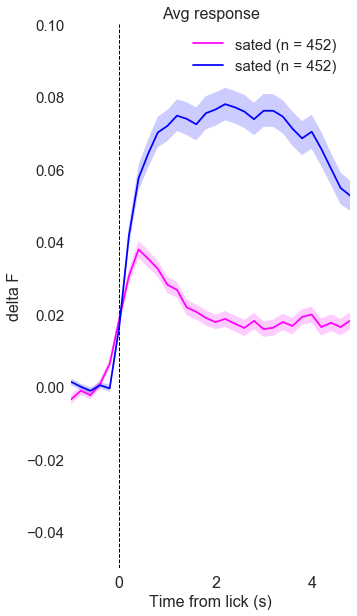

In [15]:
## Compare rewarded and unrewarded licks (Fig. S5C) ##

%cd 'C:\Users\Stuber Lab\Desktop\Raw data\satiety imaging\pre hungry'
basedir1 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\satiety imaging\\Pre hungry'
framerate=5
maxtrials=10    #number of trials
framespertrial=30
numpreframes=5
normalize_on=['yes']
baseline=[0,5]
test=[5,20]

## truncate data from above and re-normalize it by the new params##
avg_response_rew=avg_response2[10:40,:]
avg_response_rew_norm=np.nan*np.zeros((avg_response_rew.shape))
avg_response_rew_bl=np.nanmean(avg_response_rew[baseline[0]:baseline[1],:],axis=0)
for i in range(0,avg_response_rew.shape[1]):
    avg_response_rew_norm[:,i]=avg_response_rew[:,i]-avg_response_rew_bl[i]

## Load files in basedir1 and basedir2
def load_files(directory):
    signals_pop = np.nan*np.zeros((maxtrials,framespertrial,maxnumneurons))
    data_dirs = os.walk(directory).next()[1]
    numneuronstillnow = 0
    for data_dir in data_dirs:
        signals=np.load(os.path.join(directory,data_dir,'lick_before_reward.npy'))
        numneurons=signals.shape[2]
        numframes=signals.shape[1]
        numtrials=signals.shape[0]
#         numtrials=maxtrials
        for a in range(0,numneurons):
            signals_pop[0:numtrials,0:signals.shape[1],numneuronstillnow+a]=signals[0:maxtrials,:,a]
        numneuronstillnow += numneurons
    extractedsignals=signals_pop[:,:,:numneuronstillnow]
    return extractedsignals,numneuronstillnow,numframes,numneurons,numtrials
extractedsignals1,numneuronstillnow1,numframes1,numneurons1,numtrials1=load_files(basedir1)

#normalize data by baseline period
if normalize_on[0]=='yes':
    def normalize_data(data):
        BLnorm=np.nan*np.zeros((data.shape))
        BLavg=np.nan*np.zeros((data.shape[0],data.shape[2]))
        for b in range(0,data.shape[2]):
            for a in range(0,data.shape[0]):
                BLavg[a,b]=np.nanmean(data[a,baseline[0]:baseline[1],b])
        for e in range(0,data.shape[2]):
            for d in range(0,data.shape[1]):
                for c in range(0,data.shape[0]):
                    BLnorm[c,d,e]=data[c,d,e]-BLavg[c,e]
        reshape_response=BLnorm
        return reshape_response
    extractedsignals1_norm=normalize_data(extractedsignals1)
else:
    extractedsignals1_norm=extractedsignals1 
avg_response1=np.nanmean(extractedsignals1_norm,axis=0)
avg_rew_response1=np.nanmean(avg_response1[test[0]:test[1],:],axis=0)

#remove frames preceding start of baseline window
avg_response1=avg_response1[baseline[0]:,:]
avg_rew_response2=np.nanmean(avg_response_rew,axis=0)
framespertrial=framespertrial-baseline[0]
if save_files[0]=='yes':
    np.savetxt(filename+'_avg_response_unrewarded_licks.csv',avg_response1.T,delimiter=',')
    np.savetxt(filename+'_avg_response_rewarded_licks.csv',avg_response_rew_norm.T,delimiter=',')
ymin=-.05
ymax=.10
sns.set(font_scale=1.5)
fig1,ax = plt.subplots(figsize=(5,10))
sns.tsplot(avg_response1.T,color='magenta', condition=condition[0]+' (n = '+str(extractedsignals1.shape[2])+')', legend=True)
sns.tsplot(avg_response_rew_norm.T,color='blue', condition=condition[0]+' (n = '+str(extractedsignals1.shape[2])+')', legend=True)
ax.set_title('Avg response',fontsize='16')
ax.set_xlabel('Time from lick (s)',fontsize='16')
ax.set_ylabel('delta F',fontsize='16')
ax.set_axis_bgcolor('white')
ax.set_ylim(ymin,ymax)
ax.set_xticks(range(5, framespertrial+1, 10))
ax.set_xticklabels([str(((a-(numpreframes-baseline[0])+5)/framerate)) for a in range(0, framespertrial+1, 10)],fontsize='16')
ax.plot([numpreframes-baseline[0], numpreframes-baseline[0]], [ymin, ymax], '--k', linewidth=1)
ax.plot([0, framespertrial], [1, 1], '--k', linewidth=1)
if save_figs[0]=='yes':
    plt.savefig((filename+'_pop_response_overlay'+'.pdf'), format='pdf')
    plt.savefig((filename+'_pop_response_overlay'+'.png'), format='png')
    plt.show()

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in greater
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in less
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in greater
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in less
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:111: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:119: RuntimeWarning: invalid value encountered in greater
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:120: RuntimeWarning: invalid value encountered in less


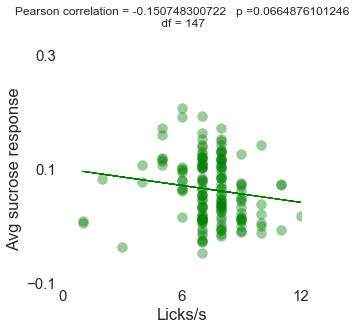

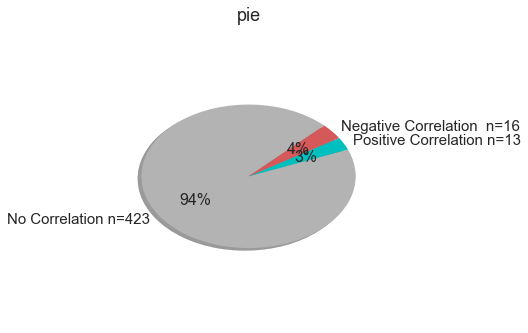

In [17]:
## Find lick rate correlation (Fig. S5D,E)

basedir1 = '\\Users\\Stuber Lab\\Desktop\\Raw data\\satiety imaging\\Pre hungry'
maxnumtrials = 1000
maxframes=2000
framerate=5
maxtrials=10    #number of trials
framespertrial=70
numpreframes=35
baseline=[20,35]
test=[35,50]
min_bout_pause = 300 ## duration in ms to define the pause to indicate the end of a bout of licking

## Load files in basedir1
def load_files(directory):
    signals_pop = np.nan*np.zeros((maxtrials,framespertrial,maxnumneurons))
    corr_pop = np.nan*np.zeros((maxnumneurons,2))
    licks_pop=np.nan*np.zeros((500,4))
    data_dirs = os.walk(directory).next()[1]
    numneuronstillnow = 0
    numtrialstillnow = 0
    pop_avg=np.nan*np.zeros((len(data_dirs),3))
    for data_dir in data_dirs:
        try:
            signals=np.load(os.path.join(directory,data_dir,'lick_align.npy'))
        except:
            continue
        numneurons=signals.shape[2]
        numframes=signals.shape[1]
        numtrials=signals.shape[0]
        #find licks aligned to first lick after reward delivery
        if numtrials>0:
            behaviordata = sio.loadmat(os.path.join(directory,data_dir, 'results.mat'))
            firstlickafterreward = behaviordata['firstlickafterCSplus']
            licks=behaviordata['licks']
            numtimesampleslick = 14 #How many do you want to plot around the cue?
            baselineframenumberlick = 7 #How many frames per trial before cue to be plotted?
            numtrialsCSpluslick = firstlickafterreward.shape[0]
            alignlick_behavior = np.zeros([numtrials,1])
            lick_bout = np.zeros([numtrials,1])
            for i in range(0,numtrials):
                alignlick_behavior[i,:]=np.count_nonzero(licks[(licks>firstlickafterreward[i]) & (licks<firstlickafterreward[i]+1000)])+1
                temp=licks[(licks>firstlickafterreward[i]) & (licks<firstlickafterreward[i]+3000)]
                temp2=np.diff(temp)
                temp3=(temp2>min_bout_pause)*1
                temp4=np.where(temp3>0)[0]
                if len(temp)>1:
                    if len(temp4)==0:
                        lick_bout[i,:]=float(temp[-1]-temp[0])/1000
                    elif len(temp4)>0:
                        lick_bout[i,:]=float(temp[temp4][0]-temp[0])/1000
            #normalize data by baseline period
            BLnorm=np.nan*np.zeros((signals.shape))
            BLavg=np.nan*np.zeros((signals.shape[0],signals.shape[2]))
            for b in range(0,signals.shape[2]):
                for a in range(0,signals.shape[0]):
                    BLavg[a,b]=np.nanmean(signals[a,baseline[0]:baseline[1],b])
            for e in range(0,signals.shape[2]):
                for d in range(0,signals.shape[1]):
                    for c in range(0,signals.shape[0]):
                        BLnorm[c,d,e]=signals[c,d,e]-BLavg[c,e]
            reshape_response=BLnorm
            avg_response=np.nanmean(reshape_response,axis=0)
            avg_cell_response=np.nanmean(reshape_response,axis=2)
            peak_response=np.nanmax(avg_response[test[0]:test[1],:],axis=0)
            avg_rew_response=np.nanmean(avg_response[test[0]:test[1],:],axis=0)

            trial_avg_response=np.nanmean(avg_cell_response[:,test[0]:test[1]],axis=1)
            trial_peak_response=np.nanmax(avg_cell_response[:,test[0]:test[1]],axis=1)
            pop_avg[data_dirs.index(data_dir),1]=np.nanmean(avg_rew_response)
            pop_avg[data_dirs.index(data_dir),2]=np.nanmean(peak_response)
            for a in range(0,numneurons):
                signals_pop[0:numtrials,0:signals.shape[1],numneuronstillnow+a]=signals[0:maxtrials,:,a]
            licks_pop[numtrialstillnow:numtrialstillnow+numtrials,0]=alignlick_behavior[0:numtrials,0]
            licks_pop[numtrialstillnow:numtrialstillnow+numtrials,1]=trial_avg_response
            licks_pop[numtrialstillnow:numtrialstillnow+numtrials,2]=trial_peak_response
            licks_pop[numtrialstillnow:numtrialstillnow+numtrials,3]=lick_bout[0:numtrials,0]
            for a in range(0,numneurons):
                temp_avg=np.nanmax(signals[:,test[0]:test[1],a], axis=1)
                r,p=stats.pearsonr(alignlick_behavior[:,0],temp_avg)
                corr_pop[numneuronstillnow+a,0]=r
                corr_pop[numneuronstillnow+a,1]=p
            numneuronstillnow += numneurons
            numtrialstillnow += numtrials
    extractedsignals=signals_pop[:,:,:numneuronstillnow]
    lick_corr_data=licks_pop[:numtrialstillnow,:]
    single_cell_corr=corr_pop[:numneuronstillnow,:]
    return extractedsignals,numneuronstillnow,numframes,numneurons,numtrials,pop_avg,data_dirs,lick_corr_data,single_cell_corr
extractedsignals1,numneuronstillnow1,numframes1,numneurons1,numtrials1,pop_avg1,data_dirs1,lick_corr1,single_cell_corr1=load_files(basedir1)
pop_avg1=np.vstack((data_dirs1,pop_avg1.T))
pop_avg1=pop_avg1.T
lick_corr1=lick_corr1[~np.isnan(lick_corr1).any(axis=1)]

xmin=0
xmax=12
ymin=-.1
ymax=.3
def plot_correlation_avg(data,name):
    r_avg,p_avg=stats.pearsonr(data[:,0],data[:,1])
    df=data.shape[0]-2
    fig,ax=plt.subplots(1,figsize=(5,5))
    ax.scatter(data[:,0],data[:,1],marker='o',color='g',alpha=0.4,s=100)
    plt.plot(data[:,0], np.poly1d(np.polyfit(data[:,0],data[:,1], 1))(data[:,0]),'g',lw=1)
    ax.set_title('Pearson correlation = '+str(r_avg)+'   p ='+str(p_avg)+'\n'+' df = '+str(df),y=1.1,fontsize='12')
    ax.set_xlabel('Licks/s')
    ax.set_ylabel('Avg sucrose response')
    ax.set_yticks([ymin,(ymin+ymax)/2,ymax])
    ax.set_xticks([xmin,(xmin+xmax)/2,xmax])
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    ax.set_axis_bgcolor('white')
    plt.tight_layout()
fig1=plot_correlation_avg(lick_corr1,name='avg_activity_Control')

def plot_sig_corr(data,pval,title):
    for a in range(0,data.shape[0]):
        if data[a,1]>=pval:
            data[a,:]=np.nan
    count_positive=np.count_nonzero(data[:,0]>0)       
    count_negative=np.count_nonzero(data[:,0]<0)
    count_null=data.shape[0]-(count_positive+count_negative)
    frequency_population = np.zeros((3,4)) #3 response types x 4 trial types
    frequency_response = np.array([count_null, count_positive, count_negative])
    frequency_population[:,0] = frequency_response
    plt.rcParams['font.size'] = 16
    fig,ax=plt.subplots(1)
    ax.set_title(title, y=1)
    ax.pie(frequency_response, autopct='%1.0f%%', shadow=True, startangle=45, 
           colors=[(0.7, 0.7,0.7),'c',(0.84, 0.35, 0.35)],
           labels=['No Correlation n='+str(count_null), 'Positive Correlation n='+str(count_positive), 'Negative Correlation  n='+str(count_negative)],
           radius=.6,labeldistance=1.1)
    return fig
fig5=plot_sig_corr(single_cell_corr1,0.05,'pie')